## We have divided the problem into two parts
(a) Predict the floor number
(b) Predict the way points or location on that floor

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from pathlib import Path
pd.options.mode.chained_assignment = None  # default='warn'
from dataclasses import dataclass
from sklearn import preprocessing

In [ ]:
import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Function to connect waypoint coordinates with straight lines
#This will be used for second part of project.We will discuss about this later.
def connect_waypoints(wp_df):
  if(wp_df.at[0,'waypoint_val1']==''):
    wp_df.at[0,'waypoint_val1']=0
  if(wp_df.at[0,'waypoint_val2']==''):
    wp_df.at[0,'waypoint_val2']=0  
  j=0
  i=0
  last=0
  #print(wp_df.head(5))
  while i < (len(wp_df)-1):
    j=i+1
    while((wp_df.at[j,'waypoint_val1']==0) and (wp_df.at[j,'waypoint_val2']==0) ):
      if(j==len(wp_df)-1):
        wp_df.at[j,'waypoint_val1']=wp_df.at[i,'waypoint_val1']
        wp_df.at[j,'waypoint_val2']=wp_df.at[i,'waypoint_val2']
        last=1
        break
      j+=1
    temp_arrayx=np.linspace(wp_df.at[i,'waypoint_val1'],wp_df.at[j,'waypoint_val1'], num=j-i+1)
    temp_arrayy=np.linspace(wp_df.at[i,'waypoint_val2'],wp_df.at[j,'waypoint_val2'], num=j-i+1)
    #print(temp_arrayx)
    m=0
    for k in range(i,j+1):
      wp_df.at[k,'waypoint_val1']=temp_arrayx[m]
      wp_df.at[k,'waypoint_val2']=temp_arrayy[m]
      #For final comparison of our predicted location, we will need to mark which waypoints were in original data before connecting them
      #print('k=',k,'i=',i,'j=',j)
      if((k==i) and (last==0)):
        wp_df.at[k,'interpolated']=1 #original waypoints
      else:
        wp_df.at[k,'interpolated']=0  #interpolated waypoints
      m+=1
    i=j
  return wp_df     


In [ ]:
# Function to extract arrays for each sensor with timeslots.
# This particular function is modified from the function provided by the competition's github page at https://github.com/location-competition/indoor-location-competition-20/blob/master/io_f.py

@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []
    line_count=0
    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        #line_count=line_count+1
        #if(line_count>3000):
        #  break
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = int(line_data[0])
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = int(line_data[0])
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce,dtype=np.float)
    acce_uncali = np.array(acce_uncali,dtype=np.float)
    gyro = np.array(gyro,dtype=np.float)
    gyro_uncali = np.array(gyro_uncali,dtype=np.float)
    magn = np.array(magn,dtype=np.float)
    magn_uncali = np.array(magn_uncali,dtype=np.float)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [ ]:
#Function to go through all the files in the folder and return the sensor data 
# in the form of arrays
@dataclass
class trace:
    sequence: np.ndarray
    target_seq: np.ndarray
    waypoint_seq: np.ndarray
    wp_full_seq: np.ndarray

def convert_to_df(file_path,floor,timeslots):
    pathlist = Path(file_path).rglob('*.txt')
    sequence = list()
    target_seq=list()
    waypoint_seq=list()
    wp_full_seq=list()
    path_id=1
    floor_trace_df=pd.DataFrame()
    for path in pathlist:
         # because path is object not string
        path_in_str = str(path)
         # print(path_in_str)
        trace_file = read_data_file(path_in_str)
        trace_df=pd.DataFrame()
        if(trace_file.acce.size):
            acce_df=pd.DataFrame(trace_file.acce, columns=['Timestamp','acce_val1','acce_val2','acce_val3'])
        if(trace_file.acce_uncali.size):
            acce__uncal_df=pd.DataFrame(trace_file.acce_uncali, columns=['Timestamp','acce_uncal_val1','acce_uncal_val2','acce_uncal_val3'])   
        if(trace_file.gyro.size):
            gyro_df=pd.DataFrame(trace_file.gyro, columns=['Timestamp','gyro_val1','gyro_val2','gyro_val3'])
        if(trace_file.gyro_uncali.size):
            gyro_uncal_df=pd.DataFrame(trace_file.gyro_uncali, columns=['Timestamp','gyro_uncal_val1','gyro_uncal_val2','gyro_uncal_val3'])
        if(trace_file.magn.size):
            magn_df=pd.DataFrame(trace_file.magn, columns=['Timestamp','magn_val1','magn_val2','magn_val3'])
        if(trace_file.magn_uncali.size):
            magn_uncal_df=pd.DataFrame(trace_file.magn_uncali, columns=['Timestamp','magn_uncal_val1','magn_uncal_val2','magn_uncal_val3'])
        if(trace_file.ahrs.size):
            rot_df=pd.DataFrame(trace_file.ahrs, columns=['Timestamp','rot_val1','rot_val2','rot_val3'])           
        if(trace_file.wifi.size):
            wifi_df=pd.DataFrame(trace_file.wifi, columns=['Timestamp','wifi_val1','wifi_val2','wifi_val3','wifi_val4']) 
        if(trace_file.ibeacon.size):
            ibeacon_df=pd.DataFrame(trace_file.ibeacon, columns=['Timestamp','ibeacon_val1','ibeacon_val2'])    
        if(trace_file.waypoint.size):
            waypoint_df=pd.DataFrame(trace_file.waypoint, columns=['Timestamp','waypoint_val1','waypoint_val2'])
        
        #change data type of wifi dataframe timestamp and ibeacon timestamp
        wifi_df["Timestamp"] = wifi_df.Timestamp.astype(float)
        ibeacon_df["Timestamp"] = ibeacon_df.Timestamp.astype(float)
        trace_df = pd.merge(acce_df, acce__uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, gyro_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, gyro_uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, magn_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, magn_uncal_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, rot_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, wifi_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, ibeacon_df, on='Timestamp', how='outer')
        trace_df = pd.merge(trace_df, waypoint_df, on='Timestamp', how='outer')
        ###### Cast time stamp to integer
        trace_df["Timestamp"] = trace_df.Timestamp.astype(int)

        # sorting by Timestamp and deleting duplicate timeslots 
        
        trace_df.sort_values("Timestamp", inplace = True)
        trace_df = trace_df.reset_index(drop=True)
        trace_df.drop_duplicates(subset="Timestamp",keep=False, inplace=True)
        trace_df = trace_df.reset_index(drop=True)
        
        trace_df=trace_df.replace(np.nan,0)

        #keep only top 200 rows in one sequence     
        #trace_df=trace_df.head(200)

        #for i in range(0,len(trace_df)):
         # trace_df.at[i,'Timestamp']=i
        
        #trace_df['time_index'] = trace_df.index
        #print(trace_df.head())
        #trace_df['floor_name']=floor
        #trace_df['path_id']=floor+path_id
        #path_id=path_id+1
        #trace_df['wifi_df'].fillna(0)
        #trace_df['ibeacon_df'].fillna(0)
        #trace_df['wifi_df'].fillna(0)
        

        wp_df = trace_df[['waypoint_val1', 'waypoint_val2']].copy()
        wp_df=connect_waypoints(wp_df)
        wp_values=wp_df.values
        #Removing text based fields in dataframe
        trace_df=trace_df.drop(['Timestamp'], axis=1)
        trace_df=trace_df.drop(['wifi_val1'], axis=1)
        trace_df=trace_df.drop(['wifi_val2'], axis=1)
        trace_df=trace_df.drop(['ibeacon_val1'], axis=1)
        trace_df.astype('float32')        
        trace_df=trace_df.drop(['waypoint_val1','waypoint_val2'], axis=1)
        #floor_trace_df=floor_trace_df.append(trace_df)
        values = trace_df.values 


        


        #Now split sequence into required number of timeslots
        l=int(len(values)/timeslots)
        k=0
        for m in range(l):
          s_temp=values[k:k+timeslots]
          wp_temp=wp_values[k:k+timeslots]
          #Normalize
          #min_max_scaler = preprocessing.MinMaxScaler()
          #s_scaled = min_max_scaler.fit_transform(s_temp)
          sequence.append(s_temp)
          wp_full_seq.append(wp_temp)
          target_seq.append(floor)
          wp_temp=wp_df.iloc[k:k+timeslots,0:]
          wp_temp=wp_temp.reset_index(drop=True)
          #wp_temp=connect_waypoints(wp_temp)
        #Now after connecting the waypoints, the avearge has become a wieghted average in time series
          wp_avg_x=wp_temp['waypoint_val1'].mean()
          wp_avg_y=wp_temp['waypoint_val2'].mean()
        #maximum and minimum will be useful in second part
          wp_max_x=wp_temp['waypoint_val1'].max()
          wp_min_x=wp_temp['waypoint_val1'].min()
          wp_max_y=wp_temp['waypoint_val2'].max()
          wp_min_y=wp_temp['waypoint_val2'].min()
          
          waypoint_seq.append([wp_avg_x,wp_avg_y,wp_max_x,wp_min_x,wp_max_y,wp_min_y])
          k+=timeslots

    return trace(sequence,target_seq,waypoint_seq,wp_full_seq)

In [ ]:
#Extracting data for B1 floor only
sequences = list()
target_sequence=list()
waypoint_sequence=list()
waypoint_full_sequence=list()
#floors_df=pd.DataFrame()
file_path = '/content/drive/MyDrive/building1/data/B1'
trace_values=(convert_to_df(file_path,0,5))
sequences.extend(trace_values.sequence)
target_sequence.extend(trace_values.target_seq)
waypoint_sequence.extend(trace_values.waypoint_seq)
waypoint_full_sequence.extend(trace_values.wp_full_seq)

In [ ]:
waypoint_sequence[0]

[198.39352660531696,
 163.5148854601227,
 198.41872321063394,
 198.36833,
 163.52063,
 163.50914092024541]

In [ ]:
len(sequences[0])

5

In [ ]:
print('Number of sequences',len(sequences))
print('Number of targets',len(target_sequence))
print('Number of timeslots in first sequence',(sequences[0].shape)[0])
print('Number of timeslots in tenth sequence',(sequences[9].shape)[0])
print('Number of timeslots in hundredth sequence',(sequences[99].shape)[0])

Number of sequences 44943
Number of targets 44943
Number of timeslots in first sequence 5
Number of timeslots in tenth sequence 5
Number of timeslots in hundredth sequence 5


# Part 2 

### After knowing the floor, now we need to predict waypoints on that floor.

### We assume that floor B1 was predicted in first part. So, for this part we will only take data of floor B1.

In [ ]:
len(waypoint_sequence)

44943

In [ ]:
len(sequences)

44943

In [ ]:
##We will divide the area into grids. But first we need to know the dimensions to work with
wp_df = pd.DataFrame(waypoint_sequence, columns = ['avg_x','avg_y','max_x','min_x','max_y','min_y',])
wp_df=wp_df.head(len(sequences))  #number of sequences for floor B1
wp_df = wp_df.round(decimals=5)
floor_max_x=wp_df['max_x'].max()
floor_min_x=wp_df['min_x'].min()
floor_max_y=wp_df['max_y'].max()
floor_min_y=wp_df['min_y'].min()
print(floor_max_x,floor_min_x,floor_max_y,floor_min_y)

233.94418 36.63454 192.99721 75.00506


In [ ]:
#Creating grid for labelling
#We will create a 10X10 grid for 100 labels
array_x=np.linspace(floor_min_x,floor_max_x,11)
array_y=np.linspace(floor_min_y,floor_max_y,11)
label=list()
k=0
for j in range(1,11):
  for i in range(1,11):
    label.append([array_x[i],array_y[j],k])
    k+=1  

In [ ]:
#Now we need to give labels to our waypoints sequence on the basis of average waypoints
print(wp_df.head())
for i in range(len(wp_df)):
  for j in range(len(label)):
    if(wp_df.at[i,'avg_x']<=label[j][0]):
       for p in range(len(label)):
         if(wp_df.at[i,'avg_y']<=label[p][1]):
           wp_df.at[i,'label']=label[j+p][2]
           break
       break    
print(wp_df.head(20))           

       avg_x      avg_y      max_x      min_x      max_y      min_y
0  198.39353  163.51489  198.41872  198.36833  163.52063  163.50914
1  198.45652  163.50052  198.48171  198.43132  163.50627  163.49478
2  198.51951  163.48616  198.54471  198.49431  163.49191  163.48042
3  198.58250  163.47180  198.60770  198.55730  163.47755  163.46606
4  198.64549  163.45744  198.67069  198.62030  163.46318  163.45170
        avg_x      avg_y      max_x      min_x      max_y      min_y  label
0   198.39353  163.51489  198.41872  198.36833  163.52063  163.50914   78.0
1   198.45652  163.50052  198.48171  198.43132  163.50627  163.49478   78.0
2   198.51951  163.48616  198.54471  198.49431  163.49191  163.48042   78.0
3   198.58250  163.47180  198.60770  198.55730  163.47755  163.46606   78.0
4   198.64549  163.45744  198.67069  198.62030  163.46318  163.45170   78.0
5   198.70848  163.44308  198.73368  198.68329  163.44882  163.43733   78.0
6   198.77148  163.42872  198.79667  198.74628  163.43446  1

In [ ]:
#Now we need to create new train, validation and test split for only building 1
train_length=int(len(sequences)*0.7)
val_length=int(len(sequences)*0.15)
test_length=len(sequences)-train_length-val_length

train_flags=np.full((train_length), 0)
validation_flags=np.full((val_length), 1)
test_flags=np.full((test_length), 2)

flags=[]
flags.extend(train_flags)
flags.extend(validation_flags)
flags.extend(test_flags)
np.random.shuffle(flags)
len(flags)

44943

In [ ]:
#Creating target sequence
target_sequence2=wp_df['label'].values
#Slice the sequence to get only floor B1 data
sequences2=sequences[0:len(sequences)]
target_sequence2=np.array(target_sequence2)
target_sequence2

array([78., 78., 78., ..., 73., 73., 73.])

In [ ]:
train = [sequences2[i] for i in range(len(flags)) if (flags[i]==0)]
validation = [sequences2[i] for i in range(len(flags)) if flags[i]==1]
test = [sequences2[i] for i in range(len(flags)) if flags[i]==2]
test_seq_wp=[waypoint_full_sequence[i] for i in range(len(flags)) if flags[i]==2]

train_target = [target_sequence2[i] for i in range(len(flags)) if (flags[i]==0)]
validation_target = [target_sequence2[i] for i in range(len(flags)) if flags[i]==1]
test_target = [target_sequence2[i] for i in range(len(flags)) if flags[i]==2]
train = np.array(train)
validation = np.array(validation)
test = np.array(test)

train_target = np.array(train_target)
train_target=to_categorical(train_target,num_classes = 100)

validation_target = np.array(validation_target)
validation_target=to_categorical(validation_target,num_classes = 100)
test_target = np.array(test_target)
test_target=to_categorical(test_target,num_classes = 100)

In [ ]:
print(sequences2[0].shape)
train_target[0]
len(test_seq_wp)

(5, 24)


6742

In [ ]:
train=tf.convert_to_tensor(train, np.float32)
train_target=tf.convert_to_tensor(train_target, np.float32)
validation=tf.convert_to_tensor(validation, np.float32)
validation_target=tf.convert_to_tensor(validation_target, np.float32)
test=tf.convert_to_tensor(test, np.float32)
test_target=tf.convert_to_tensor(test_target, np.float32)

In [ ]:
#Trial with 100 grid cells 
from keras.layers import Dropout
seq_len = 5
seq_bredth=24
model = Sequential()
model.add(Bidirectional(LSTM(256,return_sequences=True),input_shape=(seq_len, seq_bredth),merge_mode='concat'))
model.add(LSTM(256, input_shape=(3, 512)))
model.add(Dense(100, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 5, 512)            575488    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25700     
Total params: 1,388,644
Trainable params: 1,388,644
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#This is 100 cells simple LSTM
adam = Adam(lr=0.001)
checkpoint_filepath = '/content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl'
chk = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model.fit(train, train_target, epochs=200, batch_size=128, callbacks=[chk], validation_data=(validation,validation_target))

Epoch 1/200
246/246 [==============================] - 44s 157ms/step - loss: 3.4144 - accuracy: 0.1263 - val_loss: 2.3627 - val_accuracy: 0.2830

Epoch 00001: val_accuracy improved from -inf to 0.28304, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 2/200
246/246 [==============================] - 37s 149ms/step - loss: 2.0515 - accuracy: 0.3471 - val_loss: 1.6425 - val_accuracy: 0.4557

Epoch 00002: val_accuracy improved from 0.28304 to 0.45572, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 3/200
246/246 [==============================] - 38s 153ms/step - loss: 1.5947 - accuracy: 0.4597 - val_loss: 1.3813 - val_accuracy: 0.5191

Epoch 00003: val_accuracy improved from 0.45572 to 0.51906, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 4/200
246/246 [==============================] - 38s 153ms/step - loss: 1.3624 - accuracy: 0.5190 - val_loss: 1.2869 - val_accuracy: 0.5400

Epoch 00004: val_accuracy improved from 0.51906 to 0.53998, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 5/200
246/246 [==============================] - 38s 154ms/step - loss: 1.2583 - accuracy: 0.5537 - val_loss: 1.1837 - val_accuracy: 0.5759

Epoch 00005: val_accuracy improved from 0.53998 to 0.57588, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 6/200
246/246 [==============================] - 38s 155ms/step - loss: 1.1326 - accuracy: 0.5918 - val_loss: 1.1443 - val_accuracy: 0.5937

Epoch 00006: val_accuracy improved from 0.57588 to 0.59368, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 7/200
246/246 [==============================] - 38s 154ms/step - loss: 1.0583 - accuracy: 0.6208 - val_loss: 1.1434 - val_accuracy: 0.5947

Epoch 00007: val_accuracy improved from 0.59368 to 0.59472, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 8/200
246/246 [==============================] - 37s 151ms/step - loss: 1.0081 - accuracy: 0.6389 - val_loss: 1.0501 - val_accuracy: 0.6294

Epoch 00008: val_accuracy improved from 0.59472 to 0.62943, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 9/200
246/246 [==============================] - 37s 151ms/step - loss: 0.9516 - accuracy: 0.6565 - val_loss: 1.0165 - val_accuracy: 0.6352

Epoch 00009: val_accuracy improved from 0.62943 to 0.63522, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 10/200
246/246 [==============================] - 38s 153ms/step - loss: 0.8924 - accuracy: 0.6806 - val_loss: 0.9696 - val_accuracy: 0.6469

Epoch 00010: val_accuracy improved from 0.63522 to 0.64694, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 11/200
246/246 [==============================] - 37s 151ms/step - loss: 0.8411 - accuracy: 0.6954 - val_loss: 1.0671 - val_accuracy: 0.6263

Epoch 00011: val_accuracy did not improve from 0.64694
Epoch 12/200
246/246 [==============================] - 37s 151ms/step - loss: 0.8133 - accuracy: 0.7054 - val_loss: 1.0251 - val_accuracy: 0.6334

Epoch 00012: val_accuracy did not improve from 0.64694
Epoch 13/200
246/246 [==============================] - 37s 151ms/step - loss: 0.7768 - accuracy: 0.7200 - val_loss: 0.8601 - val_accuracy: 0.6903

Epoch 00013: val_accuracy improved from 0.64694 to 0.69025, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 14/200
246/246 [==============================] - 37s 151ms/step - loss: 0.7164 - accuracy: 0.7435 - val_loss: 0.8557 - val_accuracy: 0.6906

Epoch 00014: val_accuracy improved from 0.69025 to 0.69055, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 15/200
246/246 [==============================] - 37s 151ms/step - loss: 0.7019 - accuracy: 0.7437 - val_loss: 0.8501 - val_accuracy: 0.6962

Epoch 00015: val_accuracy improved from 0.69055 to 0.69619, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 16/200
246/246 [==============================] - 37s 151ms/step - loss: 0.6454 - accuracy: 0.7678 - val_loss: 0.8586 - val_accuracy: 0.6831

Epoch 00016: val_accuracy did not improve from 0.69619
Epoch 17/200
246/246 [==============================] - 37s 151ms/step - loss: 0.6611 - accuracy: 0.7604 - val_loss: 0.8082 - val_accuracy: 0.7049

Epoch 00017: val_accuracy improved from 0.69619 to 0.70494, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 18/200
246/246 [==============================] - 37s 151ms/step - loss: 0.5857 - accuracy: 0.7909 - val_loss: 0.7920 - val_accuracy: 0.7162

Epoch 00018: val_accuracy improved from 0.70494 to 0.71621, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 19/200
246/246 [==============================] - 38s 155ms/step - loss: 0.5541 - accuracy: 0.8009 - val_loss: 0.7892 - val_accuracy: 0.7149

Epoch 00019: val_accuracy did not improve from 0.71621
Epoch 20/200
246/246 [==============================] - 38s 156ms/step - loss: 0.5644 - accuracy: 0.7954 - val_loss: 0.8020 - val_accuracy: 0.7153

Epoch 00020: val_accuracy did not improve from 0.71621
Epoch 21/200
246/246 [==============================] - 38s 155ms/step - loss: 0.5252 - accuracy: 0.8108 - val_loss: 0.8074 - val_accuracy: 0.7134

Epoch 00021: val_accuracy did not improve from 0.71621
Epoch 22/200
246/246 [==============================] - 38s 156ms/step - loss: 0.5286 - accuracy: 0.8115 - val_loss: 0.8142 - val_accuracy: 0.7097

Epoch 00022: val_accuracy did not improve from 0.71621
Epoch 23/200
246/246 [==============================] - 38s 156ms/step - loss: 0.4759 - accuracy: 0.8280 - val_loss: 0.7405 - val_accuracy: 0.7294

Epoch 00023: val_accuracy improved from 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 24/200
246/246 [==============================] - 39s 158ms/step - loss: 0.4430 - accuracy: 0.8434 - val_loss: 0.8061 - val_accuracy: 0.7190

Epoch 00024: val_accuracy did not improve from 0.72942
Epoch 25/200
246/246 [==============================] - 39s 157ms/step - loss: 0.4537 - accuracy: 0.8380 - val_loss: 0.7513 - val_accuracy: 0.7361

Epoch 00025: val_accuracy improved from 0.72942 to 0.73609, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 26/200
246/246 [==============================] - 39s 157ms/step - loss: 0.4341 - accuracy: 0.8423 - val_loss: 0.7477 - val_accuracy: 0.7331

Epoch 00026: val_accuracy did not improve from 0.73609
Epoch 27/200
246/246 [==============================] - 39s 158ms/step - loss: 0.4547 - accuracy: 0.8405 - val_loss: 0.7248 - val_accuracy: 0.7441

Epoch 00027: val_accuracy improved from 0.73609 to 0.74410, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 28/200
246/246 [==============================] - 39s 158ms/step - loss: 0.3692 - accuracy: 0.8692 - val_loss: 0.8085 - val_accuracy: 0.7224

Epoch 00028: val_accuracy did not improve from 0.74410
Epoch 29/200
246/246 [==============================] - 39s 158ms/step - loss: 0.4453 - accuracy: 0.8412 - val_loss: 0.7443 - val_accuracy: 0.7416

Epoch 00029: val_accuracy did not improve from 0.74410
Epoch 30/200
246/246 [==============================] - 38s 156ms/step - loss: 0.3496 - accuracy: 0.8765 - val_loss: 0.7518 - val_accuracy: 0.7371

Epoch 00030: val_accuracy did not improve from 0.74410
Epoch 31/200
246/246 [==============================] - 39s 158ms/step - loss: 0.3467 - accuracy: 0.8794 - val_loss: 0.7596 - val_accuracy: 0.7354

Epoch 00031: val_accuracy did not improve from 0.74410
Epoch 32/200
246/246 [==============================] - 39s 159ms/step - loss: 0.3191 - accuracy: 0.8880 - val_loss: 0.7403 - val_accuracy: 0.7408

Epoch 00032: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 34/200
246/246 [==============================] - 39s 159ms/step - loss: 0.2838 - accuracy: 0.9029 - val_loss: 0.7672 - val_accuracy: 0.7428

Epoch 00034: val_accuracy did not improve from 0.74618
Epoch 35/200
246/246 [==============================] - 39s 159ms/step - loss: 0.2980 - accuracy: 0.8971 - val_loss: 0.7880 - val_accuracy: 0.7321

Epoch 00035: val_accuracy did not improve from 0.74618
Epoch 36/200
246/246 [==============================] - 39s 158ms/step - loss: 0.2717 - accuracy: 0.9071 - val_loss: 0.9238 - val_accuracy: 0.6975

Epoch 00036: val_accuracy did not improve from 0.74618
Epoch 37/200
246/246 [==============================] - 39s 158ms/step - loss: 0.3190 - accuracy: 0.8883 - val_loss: 0.7172 - val_accuracy: 0.7570

Epoch 00037: val_accuracy improved from 0.74618 to 0.75701, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 38/200
246/246 [==============================] - 39s 159ms/step - loss: 0.2190 - accuracy: 0.9261 - val_loss: 0.7315 - val_accuracy: 0.7514

Epoch 00038: val_accuracy did not improve from 0.75701
Epoch 39/200
246/246 [==============================] - 40s 161ms/step - loss: 0.2529 - accuracy: 0.9152 - val_loss: 0.7570 - val_accuracy: 0.7457

Epoch 00039: val_accuracy did not improve from 0.75701
Epoch 40/200
246/246 [==============================] - 39s 160ms/step - loss: 0.2149 - accuracy: 0.9284 - val_loss: 0.7307 - val_accuracy: 0.7619

Epoch 00040: val_accuracy improved from 0.75701 to 0.76190, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 41/200
246/246 [==============================] - 39s 157ms/step - loss: 0.2600 - accuracy: 0.9106 - val_loss: 0.7143 - val_accuracy: 0.7640

Epoch 00041: val_accuracy improved from 0.76190 to 0.76398, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 42/200
246/246 [==============================] - 39s 158ms/step - loss: 0.1963 - accuracy: 0.9345 - val_loss: 0.7719 - val_accuracy: 0.7508

Epoch 00042: val_accuracy did not improve from 0.76398
Epoch 43/200
246/246 [==============================] - 39s 157ms/step - loss: 0.2318 - accuracy: 0.9220 - val_loss: 0.7532 - val_accuracy: 0.7532

Epoch 00043: val_accuracy did not improve from 0.76398
Epoch 44/200
246/246 [==============================] - 39s 157ms/step - loss: 0.2092 - accuracy: 0.9303 - val_loss: 0.7531 - val_accuracy: 0.7561

Epoch 00044: val_accuracy did not improve from 0.76398
Epoch 45/200
246/246 [==============================] - 39s 157ms/step - loss: 0.1950 - accuracy: 0.9359 - val_loss: 0.9137 - val_accuracy: 0.7186

Epoch 00045: val_accuracy did not improve from 0.76398
Epoch 46/200
246/246 [==============================] - 39s 158ms/step - loss: 0.2185 - accuracy: 0.9266 - val_loss: 0.8664 - val_accuracy: 0.7245

Epoch 00046: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 48/200
246/246 [==============================] - 39s 158ms/step - loss: 0.1521 - accuracy: 0.9522 - val_loss: 0.7282 - val_accuracy: 0.7696

Epoch 00048: val_accuracy improved from 0.76799 to 0.76962, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 49/200
246/246 [==============================] - 39s 158ms/step - loss: 0.1475 - accuracy: 0.9534 - val_loss: 0.7604 - val_accuracy: 0.7619

Epoch 00049: val_accuracy did not improve from 0.76962
Epoch 50/200
246/246 [==============================] - 39s 158ms/step - loss: 0.2281 - accuracy: 0.9236 - val_loss: 0.7707 - val_accuracy: 0.7607

Epoch 00050: val_accuracy did not improve from 0.76962
Epoch 51/200
246/246 [==============================] - 39s 158ms/step - loss: 0.1377 - accuracy: 0.9567 - val_loss: 0.7593 - val_accuracy: 0.7635

Epoch 00051: val_accuracy did not improve from 0.76962
Epoch 52/200
246/246 [==============================] - 39s 157ms/step - loss: 0.1395 - accuracy: 0.9540 - val_loss: 0.7710 - val_accuracy: 0.7619

Epoch 00052: val_accuracy did not improve from 0.76962
Epoch 53/200
246/246 [==============================] - 39s 157ms/step - loss: 0.1869 - accuracy: 0.9365 - val_loss: 1.0529 - val_accuracy: 0.6969

Epoch 00053: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 55/200
246/246 [==============================] - 39s 158ms/step - loss: 0.1258 - accuracy: 0.9608 - val_loss: 0.8255 - val_accuracy: 0.7575

Epoch 00055: val_accuracy did not improve from 0.77659
Epoch 56/200
246/246 [==============================] - 39s 157ms/step - loss: 0.1436 - accuracy: 0.9515 - val_loss: 0.8127 - val_accuracy: 0.7564

Epoch 00056: val_accuracy did not improve from 0.77659
Epoch 57/200
246/246 [==============================] - 39s 157ms/step - loss: 0.1486 - accuracy: 0.9489 - val_loss: 0.7810 - val_accuracy: 0.7668

Epoch 00057: val_accuracy did not improve from 0.77659
Epoch 58/200
246/246 [==============================] - 39s 157ms/step - loss: 0.1038 - accuracy: 0.9694 - val_loss: 0.7597 - val_accuracy: 0.7747

Epoch 00058: val_accuracy did not improve from 0.77659
Epoch 59/200
246/246 [==============================] - 39s 157ms/step - loss: 0.2069 - accuracy: 0.9337 - val_loss: 0.7968 - val_accuracy: 0.7668

Epoch 00059: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 63/200
246/246 [==============================] - 39s 157ms/step - loss: 0.1218 - accuracy: 0.9592 - val_loss: 0.8335 - val_accuracy: 0.7570

Epoch 00063: val_accuracy did not improve from 0.77793
Epoch 64/200
246/246 [==============================] - 39s 159ms/step - loss: 0.1308 - accuracy: 0.9570 - val_loss: 0.8453 - val_accuracy: 0.7598

Epoch 00064: val_accuracy did not improve from 0.77793
Epoch 65/200
246/246 [==============================] - 39s 158ms/step - loss: 0.1280 - accuracy: 0.9572 - val_loss: 0.7786 - val_accuracy: 0.7720

Epoch 00065: val_accuracy did not improve from 0.77793
Epoch 66/200
246/246 [==============================] - 39s 157ms/step - loss: 0.1490 - accuracy: 0.9503 - val_loss: 0.8073 - val_accuracy: 0.7661

Epoch 00066: val_accuracy did not improve from 0.77793
Epoch 67/200
246/246 [==============================] - 39s 158ms/step - loss: 0.0939 - accuracy: 0.9697 - val_loss: 0.8731 - val_accuracy: 0.7494

Epoch 00067: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 88/200
246/246 [==============================] - 39s 160ms/step - loss: 0.0447 - accuracy: 0.9880 - val_loss: 0.9706 - val_accuracy: 0.7502

Epoch 00088: val_accuracy did not improve from 0.78015
Epoch 89/200
246/246 [==============================] - 39s 159ms/step - loss: 0.1362 - accuracy: 0.9538 - val_loss: 0.9131 - val_accuracy: 0.7582

Epoch 00089: val_accuracy did not improve from 0.78015
Epoch 90/200
246/246 [==============================] - 39s 158ms/step - loss: 0.1126 - accuracy: 0.9623 - val_loss: 0.8662 - val_accuracy: 0.7753

Epoch 00090: val_accuracy did not improve from 0.78015
Epoch 91/200
246/246 [==============================] - 39s 157ms/step - loss: 0.0438 - accuracy: 0.9877 - val_loss: 0.8542 - val_accuracy: 0.7760

Epoch 00091: val_accuracy did not improve from 0.78015
Epoch 92/200
246/246 [==============================] - 39s 157ms/step - loss: 0.1006 - accuracy: 0.9676 - val_loss: 1.0993 - val_accuracy: 0.7256

Epoch 00092: val_accuracy did not improv

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 100/200
246/246 [==============================] - 39s 157ms/step - loss: 0.0148 - accuracy: 0.9981 - val_loss: 0.8317 - val_accuracy: 0.7896

Epoch 00100: val_accuracy improved from 0.78742 to 0.78965, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 101/200
246/246 [==============================] - 39s 158ms/step - loss: 0.0115 - accuracy: 0.9984 - val_loss: 0.8352 - val_accuracy: 0.7899

Epoch 00101: val_accuracy improved from 0.78965 to 0.78994, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 102/200
246/246 [==============================] - 39s 157ms/step - loss: 0.0128 - accuracy: 0.9978 - val_loss: 0.9189 - val_accuracy: 0.7695

Epoch 00102: val_accuracy did not improve from 0.78994
Epoch 103/200
246/246 [==============================] - 38s 156ms/step - loss: 0.1680 - accuracy: 0.9446 - val_loss: 0.9899 - val_accuracy: 0.7398

Epoch 00103: val_accuracy did not improve from 0.78994
Epoch 104/200
246/246 [==============================] - 39s 157ms/step - loss: 0.1293 - accuracy: 0.9572 - val_loss: 0.9397 - val_accuracy: 0.7610

Epoch 00104: val_accuracy did not improve from 0.78994
Epoch 105/200
246/246 [==============================] - 38s 156ms/step - loss: 0.0318 - accuracy: 0.9923 - val_loss: 0.8834 - val_accuracy: 0.7761

Epoch 00105: val_accuracy did not improve from 0.78994
Epoch 106/200
246/246 [==============================] - 38s 156ms/step - loss: 0.0190 - accuracy: 0.9968 - val_loss: 0.8719 - val_accuracy: 0.7853

Epoch 00106: val_accuracy did not i

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 119/200
246/246 [==============================] - 39s 159ms/step - loss: 0.0069 - accuracy: 0.9989 - val_loss: 0.9233 - val_accuracy: 0.7730

Epoch 00119: val_accuracy did not improve from 0.79113
Epoch 120/200
246/246 [==============================] - 38s 156ms/step - loss: 0.2257 - accuracy: 0.9272 - val_loss: 1.0564 - val_accuracy: 0.7216

Epoch 00120: val_accuracy did not improve from 0.79113
Epoch 121/200
246/246 [==============================] - 39s 157ms/step - loss: 0.1235 - accuracy: 0.9583 - val_loss: 0.8668 - val_accuracy: 0.7782

Epoch 00121: val_accuracy did not improve from 0.79113
Epoch 122/200
246/246 [==============================] - 39s 157ms/step - loss: 0.0215 - accuracy: 0.9959 - val_loss: 0.8406 - val_accuracy: 0.7865

Epoch 00122: val_accuracy did not improve from 0.79113
Epoch 123/200
246/246 [==============================] - 38s 156ms/step - loss: 0.0087 - accuracy: 0.9992 - val_loss: 0.8931 - val_accuracy: 0.7766

Epoch 00123: val_accuracy did not i

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 132/200
246/246 [==============================] - 39s 157ms/step - loss: 0.0073 - accuracy: 0.9985 - val_loss: 1.0138 - val_accuracy: 0.7674

Epoch 00132: val_accuracy did not improve from 0.79335
Epoch 133/200
246/246 [==============================] - 39s 158ms/step - loss: 0.1760 - accuracy: 0.9416 - val_loss: 1.0747 - val_accuracy: 0.7342

Epoch 00133: val_accuracy did not improve from 0.79335
Epoch 134/200
246/246 [==============================] - 39s 159ms/step - loss: 0.1155 - accuracy: 0.9599 - val_loss: 0.9592 - val_accuracy: 0.7616

Epoch 00134: val_accuracy did not improve from 0.79335
Epoch 135/200
246/246 [==============================] - 39s 157ms/step - loss: 0.0631 - accuracy: 0.9805 - val_loss: 0.8848 - val_accuracy: 0.7821

Epoch 00135: val_accuracy did not improve from 0.79335
Epoch 136/200
246/246 [==============================] - 39s 158ms/step - loss: 0.0125 - accuracy: 0.9980 - val_loss: 0.8609 - val_accuracy: 0.7914

Epoch 00136: val_accuracy did not i

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 139/200
246/246 [==============================] - 39s 159ms/step - loss: 0.0037 - accuracy: 0.9996 - val_loss: 0.8556 - val_accuracy: 0.7978

Epoch 00139: val_accuracy improved from 0.79380 to 0.79780, saving model to /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 140/200
246/246 [==============================] - 39s 157ms/step - loss: 0.0085 - accuracy: 0.9981 - val_loss: 1.8397 - val_accuracy: 0.6253

Epoch 00140: val_accuracy did not improve from 0.79780
Epoch 141/200
246/246 [==============================] - 39s 158ms/step - loss: 0.4573 - accuracy: 0.8577 - val_loss: 0.9758 - val_accuracy: 0.7549

Epoch 00141: val_accuracy did not improve from 0.79780
Epoch 142/200
246/246 [==============================] - 39s 158ms/step - loss: 0.0818 - accuracy: 0.9736 - val_loss: 0.9076 - val_accuracy: 0.7788

Epoch 00142: val_accuracy did not improve from 0.79780
Epoch 143/200
246/246 [==============================] - 39s 158ms/step - loss: 0.0150 - accuracy: 0.9976 - val_loss: 0.8511 - val_accuracy: 0.7852

Epoch 00143: val_accuracy did not improve from 0.79780
Epoch 144/200
246/246 [==============================] - 39s 157ms/step - loss: 0.0082 - accuracy: 0.9992 - val_loss: 0.8607 - val_accuracy: 0.7879

Epoch 00144: val_accuracy did not i

INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl/assets


Epoch 155/200
246/246 [==============================] - 39s 158ms/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 0.8715 - val_accuracy: 0.7950

Epoch 00155: val_accuracy did not improve from 0.79840
Epoch 156/200
246/246 [==============================] - 39s 157ms/step - loss: 0.0416 - accuracy: 0.9876 - val_loss: 1.4072 - val_accuracy: 0.6714

Epoch 00156: val_accuracy did not improve from 0.79840
Epoch 157/200
246/246 [==============================] - 39s 158ms/step - loss: 0.3193 - accuracy: 0.8932 - val_loss: 0.9916 - val_accuracy: 0.7524

Epoch 00157: val_accuracy did not improve from 0.79840
Epoch 158/200
246/246 [==============================] - 39s 157ms/step - loss: 0.0491 - accuracy: 0.9853 - val_loss: 0.9293 - val_accuracy: 0.7761

Epoch 00158: val_accuracy did not improve from 0.79840
Epoch 159/200
246/246 [==============================] - 39s 158ms/step - loss: 0.0218 - accuracy: 0.9939 - val_loss: 0.8856 - val_accuracy: 0.7849

Epoch 00159: val_accuracy did not i

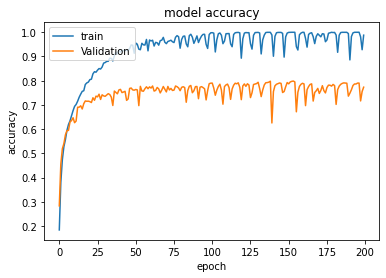

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model = load_model('/content/drive/MyDrive/building1/26March5slots_200epochs_biDirLSTMsingleDense/best_model.pkl')

from sklearn.metrics import accuracy_score
y_pred=model.predict(test)
test_preds=( y_pred> 0.5).astype("int32")#Selecting a label only if it has >0.5 probability
accuracy_score(test_target, test_preds)

0.788935034114506

In [ ]:
yhat=np.argmax(y_pred,axis=1)
y=np.argmax(test_target,axis=1)
accuracy_score(y,yhat)

0.7959062592702462

In [ ]:
#converting predicted labels to waypoins.
pred_df=pd.DataFrame(yhat,columns=['Label'])
label_df=pd.DataFrame(label,columns=['X_up_limit','Y_up_limit','Label'])
label_df.head()
pred_df2 = pd.merge(pred_df, label_df, on='Label', how='left')
pred_df2.head()

,Label,X_up_limit,Y_up_limit
0,79,233.944180,169.39878
1,78,214.213216,169.39878
2,78,214.213216,169.39878
3,78,214.213216,169.39878
4,78,214.213216,169.39878


In [ ]:
wp_pred=list()
#Adjust wp to centers
distx=(label[1][0]-label[0][0])/2
disty=(label[10][1]-label[0][1])/2 #for 10X10 grid
pred_df2['X_up_limit']=pred_df2['X_up_limit']-distx
pred_df2['Y_up_limit']=pred_df2['Y_up_limit']-disty
pred_df2.head()

,Label,X_up_limit,Y_up_limit
0,79,224.078698,163.499172
1,78,204.347734,163.499172
2,78,204.347734,163.499172
3,78,204.347734,163.499172
4,78,204.347734,163.499172


In [ ]:
#Now we will calculate exact error in predicted and actual location
#We will consider only those waypoints which were present in the original data
#to calculate error and we will reject interpolated values which were introduced by us 
import math
sum_of_error=0
sum_sq_error=0
count=0
test_predicted=pred_df2[['X_up_limit','Y_up_limit']].values
for i in range(len(test_seq_wp)):
  for j in range(len(test_seq_wp[i])):
    if(test_seq_wp[i][j][2]==1):
      sum_of_error+=math.sqrt(((test_predicted[i][0]-test_seq_wp[i][j][0])**2)+((test_predicted[i][1]-test_seq_wp[i][j][1])**2))
      sum_sq_error+=((test_predicted[i][0]-test_seq_wp[i][j][0])**2)+((test_predicted[i][1]-test_seq_wp[i][j][1])**2)
      count+=1


MAE=sum_of_error/count
RMSE=math.sqrt(sum_sq_error/count)
print('MAE value is:',round(MAE,2))  
print('RMSE value is:',round(RMSE,2)) 

MAE value is: 24.82
RMSE value is: 37.78
